<a href="https://colab.research.google.com/github/jecampagne/ML-toys/blob/main/Test_JAX_FLows_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q distrax dm-haiku optax


     |████████████████████████████████| 272 kB 9.1 MB/s 
     |████████████████████████████████| 350 kB 50.9 MB/s 
     |████████████████████████████████| 145 kB 58.9 MB/s 
     |████████████████████████████████| 85 kB 3.1 MB/s 


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16
from mpl_toolkits.axes_grid1 import make_axes_locatable


from typing import Any, Mapping, Sequence, Tuple, Iterator, Optional

import distrax
import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from distrax._src.bijectors.bijector import Array
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import tensorflow_datasets as tfds # to load MNIST

In [ ]:
print(tfp.__version__, distrax.__version__, optax.__version__, hk.__version__)

0.16.0 0.1.2 0.1.3 0.0.8


In [ ]:
#avoid boring Warnings
import logging
logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())


In [ ]:
Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any

MODEL = 'MAF' # 
TARGET_DENSITY = 'MNIST'

MNIST_IMAGE_SHAPE = (28, 28, 1)


if MODEL == 'MAF':
  FLOW_NUM_LAYERS = 8
  HIDDEN_SIZE = 512
  MLP_NUM_LAYERS = 2
  FLOW_NUM_PARAMS = 8
else:
  print("no other model implemented")





In [ ]:
def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load("mnist", split=split, shuffle_files=True)
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


In [ ]:
data_batch =  load_dataset(
        tfds.Split.TRAIN, batch_size=16)
data = next(data_batch)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [ ]:
images_dir = '/content/gdrive/MyDrive/Images'
! mkdir '/content/gdrive/MyDrive/Images'

mkdir: cannot create directory ‘/content/gdrive/MyDrive/Images’: File exists


In [ ]:
data['image'].shape, data['label'].shape,data['label'][1]

((16, 28, 28, 1), (16,), 4)

In [ ]:
def plot_image(imgs, title=''):
  imgs = imgs.squeeze()
  N=imgs.shape[0]
  cols = rows = int(np.ceil(np.sqrt(N)))
  fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows), sharey=True,sharex=True)
  for i in range(N):
      r = int(i // rows)
      c = int(i % cols)
      ax = axes[r, c]
      ax.imshow(imgs[i], cmap="gray_r")
      ax.set_xticks([])
      ax.set_yticks([])
  plt.subplots_adjust(wspace=0,hspace=0)
  fig.suptitle(title)


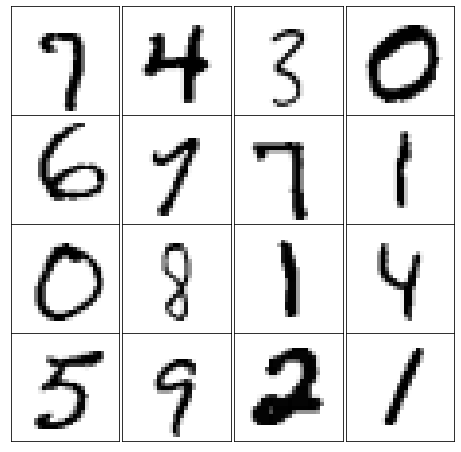

In [ ]:
plot_image(data['image'])
plt.savefig(f"{images_dir}/jax_NF_plots_{MODEL}_{TARGET_DENSITY}_true_pdf.pdf")

In [ ]:
mask = jnp.arange(0, np.prod(MNIST_IMAGE_SHAPE)) % 2  # every second element is masked
mask = jnp.reshape(mask, MNIST_IMAGE_SHAPE)
#mask = mask.astype(bool)


In [ ]:
mask.shape

(28, 28, 1)

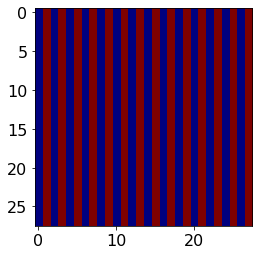

In [ ]:
plt.imshow(mask.squeeze())

In [ ]:
def make_conditioner(
    event_shape: Sequence[int], hidden_sizes: Sequence[int], num_bijector_params: int
) -> hk.Sequential:

    return hk.Sequential(
        [
            hk.Flatten(preserve_dims=-len(event_shape)),
            hk.nets.MLP(hidden_sizes, activate_final=True),
            hk.Linear(
                np.prod(event_shape) * num_bijector_params,
                w_init=jnp.zeros,
                b_init=jnp.zeros,
            ),
            hk.Reshape(tuple(event_shape) + (num_bijector_params,), preserve_dims=-1),
        ]
    )


def make_flow_model(
    event_shape: Sequence[int],
    num_layers: int,
    hidden_sizes: Sequence[int],
    flow_num_params: int,
) -> distrax.Transformed:

    mask = jnp.arange(0, np.prod(event_shape)) % 2  # every second element is masked
    mask = jnp.reshape(mask, event_shape)
    mask = mask.astype(bool)

    flow_num_params = 3 * flow_num_params + 1

    def bijector_fn(params: Array):
        return distrax.RationalQuadraticSpline(params, range_min=0.0, range_max=1.0)

    layers = []
    for _ in range(num_layers):
        layer = distrax.MaskedCoupling(
            mask=mask,
            bijector=bijector_fn,
            conditioner=make_conditioner(
                event_shape=event_shape,
                hidden_sizes=hidden_sizes,
                num_bijector_params=flow_num_params,
            ),
        )

        layers.append(layer)
        # Flip mask after each layer
        mask = jnp.logical_not(mask)

    flow = distrax.Inverse(distrax.Chain(layers))
    base_distribution = distrax.Independent(
        distrax.Uniform(low=jnp.zeros(event_shape), high=jnp.ones(event_shape)),
        reinterpreted_batch_ndims=len(event_shape),
    )
    return distrax.Transformed(base_distribution, flow)



def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:  # type: ignore
    data = batch["image"].astype(np.float32)
    if prng_key is not None:
        # Dequantize pixel values {0, 1, ..., 255} with uniform noise [0, 1).
        data += jax.random.uniform(prng_key, data.shape)
    return data / 256.0  # Normalize pixel values from [0, 256) to [0, 1).


@hk.without_apply_rng
@hk.transform
def log_prob(data: Array) -> Array:
    model = make_flow_model(
        event_shape=data.shape[1:],
        num_layers=FLOW_NUM_LAYERS,
        hidden_sizes=[HIDDEN_SIZE] * MLP_NUM_LAYERS,
        flow_num_params=FLOW_NUM_PARAMS,
    )
    return model.log_prob(data)


@hk.without_apply_rng
@hk.transform
def sample(event_shape: Tuple, prng_key: PRNGKey, num_samples: int):  # type: ignore

    model = make_flow_model(
        event_shape=event_shape,
        num_layers=FLOW_NUM_LAYERS,
        hidden_sizes=[HIDDEN_SIZE] * MLP_NUM_LAYERS,
        flow_num_params=FLOW_NUM_PARAMS,  # num_bins
    )
    return model.sample(seed=prng_key, sample_shape=(num_samples,))


@jax.jit
def loss_fn(params: hk.Params, prng_key: PRNGKey, batch: Batch) -> Array:  # type: ignore
    data = prepare_data(batch, prng_key)
    # Loss is average negative log likelihood.
    loss = -jnp.mean(log_prob.apply(params, data))
    return loss


@jax.jit
def eval_fn(params: hk.Params, batch: Batch) -> Array:
    data = prepare_data(batch)  # We don't dequantize during evaluation.
    loss = -jnp.mean(log_prob.apply(params, data))
    return loss

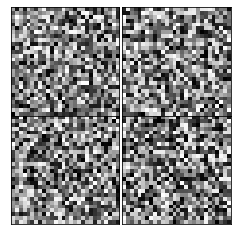

In [ ]:
N = 4
prng_seq = hk.PRNGSequence(42)
params = log_prob.init(next(prng_seq), np.zeros((1, *MNIST_IMAGE_SHAPE)))

samples = sample.apply(
        params=params,
        prng_key=next(prng_seq),
        event_shape=MNIST_IMAGE_SHAPE,
        num_samples=N,
)
# make plots
plot_image(samples)
plt.savefig(f"{images_dir}/jax_NF_plots_{MODEL}_{TARGET_DENSITY}_init_pdf.pdf")

In [ ]:
from IPython.lib.display import IFrame
def train(
    batch_size,
    learning_rate,
    training_steps,
    eval_frequency,
):
    schedule_fn = optax.polynomial_schedule(
    init_value=learning_rate, end_value=learning_rate/10., power=0.5, transition_steps=training_steps)
    optimizer = optax.adam(schedule_fn)

    @jax.jit
    def update(
        params: hk.Params, prng_key: PRNGKey, opt_state: OptState, batch: Batch
    ) -> Tuple[hk.Params, OptState]:

        """Single SGD update step."""
        grads = jax.grad(loss_fn)(params, prng_key, batch)
        updates, new_opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_opt_state

    prng_seq = hk.PRNGSequence(42)
    params = log_prob.init(next(prng_seq), np.zeros((1, *MNIST_IMAGE_SHAPE)))
    opt_state = optimizer.init(params)

    train_ds = load_dataset(tfds.Split.TRAIN, batch_size)
    valid_ds = load_dataset(tfds.Split.TEST, batch_size)


    best_params = params
    best_val_loss = jnp.inf
    all_val_loss = []

    for step in range(training_steps):
        params, opt_state = update(params, next(prng_seq), opt_state, next(train_ds))


        if step % eval_frequency == 0:
            val_loss = eval_fn(params, next(valid_ds))
            all_val_loss.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = params
          
            print(
                f"STEP: {step}; validation loss: {val_loss}"
            )

            if step % 5*eval_frequency == 0:
                N = 16
                samples = sample.apply(
                    params=params,
                    prng_key=jax.random.PRNGKey(214),  # next(prng_seq),
                    event_shape=MNIST_IMAGE_SHAPE,
                    num_samples=N,
                )
                plot_image(samples)
                plt.savefig(f"{images_dir}/jax_NF_plots_{MODEL}_{TARGET_DENSITY}_{step}_pdf.pdf")

    return best_params, all_val_loss

In [ ]:

params_fit, val_losses  = train(batch_size=128,
    learning_rate=1e-4,
    training_steps=10000,
    eval_frequency=500,
)

STEP: 0; validation loss: -5.774769306182861
STEP: 500; validation loss: -3087.270263671875
STEP: 1000; validation loss: -3107.888671875
STEP: 1500; validation loss: -3121.84912109375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


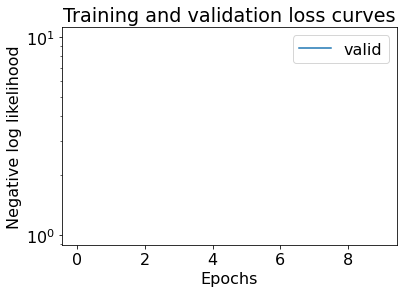

In [ ]:
plt.plot(val_losses, label='valid')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Negative log likelihood')
plt.title('Training and validation loss curves')
plt.yscale("log")
plt.show()

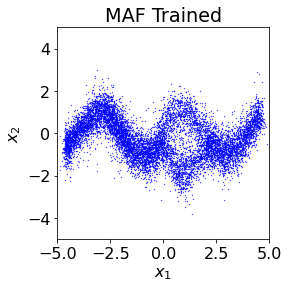

In [ ]:
samples = sample.apply(
        params=params_fit,
        prng_key=next(prng_seq),
        event_shape=(2,),
        num_samples=N,
)
# make plots
plot_range = np.array([xlim,ylim])
figsize = (8, 8)
#ax.hist2d(samples[:, 0], samples[:, 1], bins=100, range=plot_range)
plt.scatter(samples[:, 0], samples[:, 1], s=0.1, color='blue',label='Init Train')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.title(f"{MODEL} Trained")
plt.savefig(f"{images_dir}/jax_NF_plots_{MODEL}_{TARGET_DENSITY}_after_train_pdf.pdf")

In [ ]:
    # Evaluate
    #plt.savefig(f"./plots/{density}/real_nvp_{density}.jpg", dpi=750)

    # num_points = 2000
    # x1 = jnp.linspace(-4, 4, num_points)
    # x2 = jnp.linspace(-4, 4, num_points)
    # X1, X2 = jnp.meshgrid(x1, x2)

    # # pdf values of true and learned distribution
    # X1X2 = jnp.stack([X1, X2], axis=-1)
    # Z1 = dataset_pdf(X1X2)
    # Z2 = jnp.exp(log_prob.apply(params, X1X2))

    # fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    # # axes[0].contourf(X1, X2, Z1, cmap="viridis")
    # axes[1].contourf(X1, X2, Z2, cmap="viridis")
    # plt.savefig(f"plots/{DENSITY}/{DENSITY}_pdf.jpg", dpi=600)
